In [0]:
/import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets.samples_generator import make_blobs, make_moons

import warnings


sns.set(style='dark', font_scale=1.4)
warnings.filterwarnings('ignore')

### Немного теории про стратегии в мультиклассовой логистической регрессии:

Модель логистической регрессии можно обобщить для случая многоклассовой классификации. Пусть метка класса принимает значения в $K$-элементном множестве $\{(1, 0, ..., 0), (0, 1, ..., 0), ..., (0, 0, ..., 1)\}$. Параметры модели $\theta$ являются матрицей размерности $K \times d$, где $d$ − количество признаков. Обучение модели логистической регрессии в многоклассовом случае (`multinomial`) выглядит следующим образом:

$$ \sum_{i=1}^N \sum_{k=1}^K Y_{ik} \log\left[\exp\left(x_i^T \theta_k\right) \left/ \sum\limits_{s=1}^K \exp\left(x_i^T \theta_k\right) \right.\right] \to \max_{\theta}$$

Здесь $\theta_k$ обозначает $k$-ую строку матрицы $\theta$.
Обучать эту модель также можно с помощью градиентного спуска.

Кроме того существует другой, более универсальный способ решать задачу многоклассовой классификации. Для этого нужно обучить несколько бинарных моделей классификации, после чего на основании предсказаний по этим моделям вынести окончательный вердикт о принадлежности объекта одному из $K$ классов. Можно выделить две популярные стратегии использования бинарных классификаторов для задачи многоклассовой классификации:

* `OvR` (One-vs-Rest, One-vs-All) − стратегия, при которой каждый из $K$ классификаторов обучается отделять объекты одного класса от объектов всех остальных классов. В качестве предсказания используется тот класс, классификатор которого предсказал наибольшую вероятность среди всех.

* `OvO` (One-vs-One) − стратегия, при которой каждый из $\frac{K(K-1)}{2}$ классификаторов учится разделять объекты пары классов, игнорируя объекты всех остальных классов. Таким образом, каждый классификатор тренируется на подвыборке, состоящей только из двух конкретных классов. На этапе предсказания классификаторы предсказывают метку класса для объекта (именно метку, не вероятность) и для данного объекта выбирается класс, который предсказывался больше всего среди всех классификаторов.

В качестве датасета воспользуемся функцией `make_blobs` из `sklearn`. Сгенерируем выборку, разделим на обучающую и тестовую.

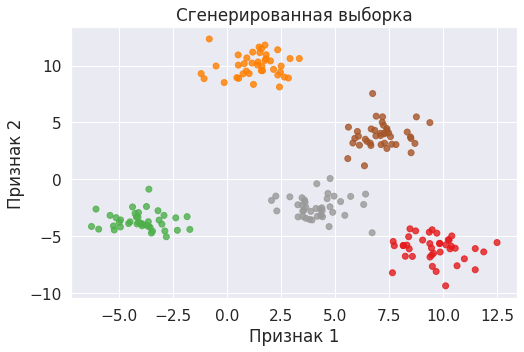

In [0]:
X, y = make_blobs(n_samples=200, centers=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Set1')
plt.grid()
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.show()

Исследуем каждую из стратегий. Для `multinomial`, `OvR` можно воспользоваться стандартным классом `LogisticRegression` из `sklearn` указав соотвествующий параметр [`multi_class`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), для `OvO` можно воспользоваться [`OneVsOneClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html).

Заведем три классификатора с различными стратегиями:

In [0]:
ovo_strategy = OneVsOneClassifier(
    LogisticRegression(), n_jobs=-1
).fit(X_train, y_train)

ovr_strategy = LogisticRegression(
    multi_class='ovr', max_iter=500, solver='lbfgs'
).fit(X_train, y_train)

multinomial = LogisticRegression(
    multi_class='multinomial', max_iter=500, solver='lbfgs'
).fit(X_train, y_train)


for clf, strategy in zip([ovo_strategy, ovr_strategy, multinomial], 
                         ['OvO', 'OvR', 'multinomial']):
    print('Accuracy for {}: {}'.format(
        strategy, accuracy_score(y_test, clf.predict(X_test))
    ))

Accuracy for OvO: 0.98
Accuracy for OvR: 0.98
Accuracy for multinomial: 0.98


Вспомогательные функции для отрисовки графиков:

In [0]:
def scatter_data(X, y, clf):
    ''' Отображаем выборку на плоскости '''
    
    colors = 'bgryw'
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, 
                    cmap='Set1', edgecolor='black', s=45)


def plot_decision_plane(X, y, clf):
    ''' Строим решающую плоскость классификатора '''

    # создаем сетку для построения графика
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), 
                         np.arange(y_min, y_max, 0.02))

    # получаем предсказания для сетки
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap='viridis')
    scatter_data(X, y, clf)
    plt.xticks([]); plt.yticks([])

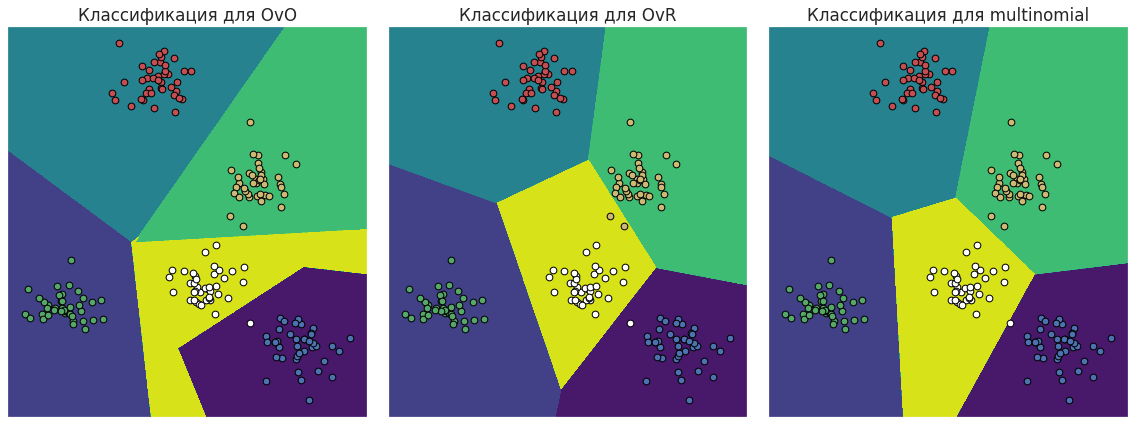

In [0]:
plt.figure(figsize=(16, 6))

for ind, (clf, strategy) in enumerate(
    zip([ovo_strategy, ovr_strategy, multinomial], 
        ['OvO', 'OvR', 'multinomial'])):
    
    plt.subplot(1, 3, ind + 1)
    plt.title('Классификация для {}'.format(strategy))
    plot_decision_plane(X, y, clf)
    
plt.tight_layout()

Для стратегий `OvO` и `OvR` параметры моделей являются коэфициентами прямых. Построим их только для стратегии `OvR`, так как для `OvO` получится слишком нагроможденная картинка:

In [0]:
def plot_hyperplanes(X, y, clf):

    def line(x0, c):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    scatter_data(X, y, clf)

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef, intercept = clf.coef_, clf.intercept_

    colors = 'bgryw'
    for i, color in zip(clf.classes_, colors):
        plt.plot([xmin, xmax], [line(xmin, i), line(xmax, i)], 
                 ls='--', color=color, lw=5)

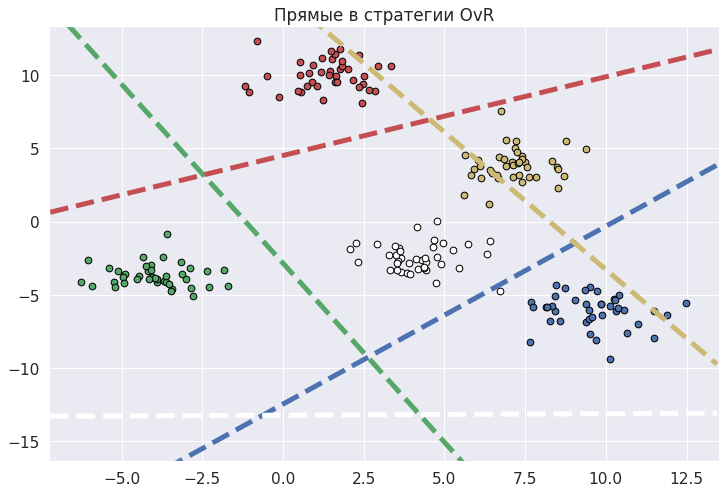

In [0]:
plt.figure(figsize=(12, 8))
plt.title('Прямые в стратегии OvR')
plot_hyperplanes(X, y, ovr_strategy)
plt.xlim((X[:, 0].min() - 1, X[:, 0].max() + 1))
plt.ylim((X[:, 1].min() - 7, X[:, 1].max() + 1))
plt.grid()

Видим, что для желтого, белого, синего классов полученная прямая хорошо отделяет его от всех остальных классов. 

**`OvO`**

- *плюсы*: обучается на более-менее сбалансированных данных (так как рассматривается только два класса). Каждый классификатор обучается на подвыборке из двух классов, следовательно обучение одного классификатора происходит быстрее, чем в `OvR`.

- *минусы*: $O\left(n_{classes}^2\right)$ классификаторов, что долго; страдает от неоднозначности, когда в точке у двух классов одинаковое количество голосов.

**`OvR`**

- *плюсы*: $O\left(n_{classes}\right)$ классификаторов.

- *минусы*: каждый классификатор обучается на несбалансированной выборке; страдает от неоднозначности, когда в точке у двух классов одинаковое количество голосов.

**`multinomial`**

- *плюсы*: один классификатор (хоть параметров столько же, сколько и в `OvR`).

- *минусы*: задача оптимизации, которую решает данная стратегия, уже гораздо сложнее, чем при бинарной классификации, поэтому обычно требуется чуть больше времени для сходимости.